# Notebook 7 — Income DKL Dodged Bar Charts

Produces dodged bar charts of `dkl_bin` by income bracket for four study cities:
Chicago, Houston, Atlanta, and New York (as defined in `config.CITIES`).

**`dkl_bin`** measures how much information a particular income bin contributes
to the overall divergence between a block group and its CBSA:
$$\text{DKL}_{\text{bin}}(j) = \sum_i p_{ni|yj} \log_2\frac{p_{ni|yj}}{p_{ni}}$$

A high `dkl_bin` for a bracket means households in that bracket are unevenly
distributed across block groups relative to the CBSA average.

**Inputs**: `data/acs5_block_{year}_data/dkl_income_{yr_short}_blkgrp_all_states.parquet`  
**Years**: 2010, 2015, 2020


In [1]:
# ── Imports ──────────────────────────────────────────────────────────────────
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

warnings.filterwarnings('ignore')

NOTEBOOK_DIR = Path().resolve()
PIPELINE_DIR = NOTEBOOK_DIR.parent
if str(PIPELINE_DIR) not in sys.path:
    sys.path.insert(0, str(PIPELINE_DIR))

from config import DATA_DIR, CITIES

sns.set_theme(style='whitegrid', font_scale=0.95)

print(f'DATA_DIR : {DATA_DIR}')
print(f'CITIES   : {CITIES}')


DATA_DIR : /Users/bettencourt/Desktop/dkl-metric/pipeline/data
CITIES   : ['Chicago-Naperville-Elgin, IL-IN-WI', 'Houston-The Woodlands-Sugar Land, TX', 'Atlanta-Sandy Springs-Alpharetta, GA', 'New York-Newark-Jersey City, NY-NJ-PA']


## 1. Load DKL Income Parquet Files

Load income DKL results for 2010, 2015, and 2020.  The files follow the naming
convention `dkl_income_{yr_short}_blkgrp_all_states.parquet`.


In [2]:
TARGET_YEARS = [2010, 2015, 2020]


def _dkl_income_path(year: int, data_dir: Path) -> Path:
    yr_short = str(year)[2:]
    return data_dir / f'acs5_block_{year}_data' / f'dkl_income_{yr_short}_blkgrp_all_states.parquet'


def load_income_dkl(years: list, data_dir: Path) -> pd.DataFrame:
    frames = []
    for yr in years:
        path = _dkl_income_path(yr, data_dir)
        if not path.exists():
            print(f'  [WARN] Not found (skipping): {path}')
            continue
        df = pd.read_parquet(path)
        df['year'] = yr
        frames.append(df)
        print(f'  Loaded {path.name}  ({len(df):,} rows)')

    if not frames:
        raise FileNotFoundError(
            'No DKL income parquet files found.  '
            'Run pipeline/2_calculate_dkl.py and/or pipeline/3_income_2010.py first.'
        )

    dkl = pd.concat(frames, ignore_index=True)
    print(f'\nTotal rows : {len(dkl):,}')
    print(f'Columns    : {list(dkl.columns)}')
    return dkl


dkl_income = load_income_dkl(TARGET_YEARS, DATA_DIR)
dkl_income.head(3)


  [WARN] Not found (skipping): /Users/bettencourt/Desktop/dkl-metric/pipeline/data/acs5_block_2010_data/dkl_income_10_blkgrp_all_states.parquet


  Loaded dkl_income_15_blkgrp_all_states.parquet  (3,210,272 rows)


  Loaded dkl_income_20_blkgrp_all_states.parquet  (3,550,928 rows)



Total rows : 6,761,200
Columns    : ['block_fips', 'county_fips', 'county_name', 'cbsa_fips', 'cbsa_title', 'area_type', 'central_outlying_county', 'state_codes', 'state_fips', 'state_name', 'variable', 'variable_group', 'variable_item', 'group_label', 'label', 'block_pct', 'block_estimate', 'moe', 'block_total', 'county_pct', 'county_estimate', 'county_total', 'cbsa_pct', 'cbsa_estimate', 'cbsa_total', 'p_ni', 'p_ni_yj', 'p_yj', 'p_yj_ni', 'dkl_log_i', 'dkl_log_j', 'dkl_block_j', 'dkl_bin_i', 'dkl_block', 'dkl_bin', 'year']


,block_fips,county_fips,county_name,cbsa_fips,cbsa_title,area_type,central_outlying_county,state_codes,state_fips,state_name,...,p_ni_yj,p_yj,p_yj_ni,dkl_log_i,dkl_log_j,dkl_block_j,dkl_bin_i,dkl_block,dkl_bin,year
0,010010201001,01001,,33860,"Montgomery, AL",Metropolitan Statistical Area,Central,AL,01,Alabama,...,0.000848,0.090809,0.046218,-0.974358,-0.974358,-0.045033,-0.000826,0.575228,0.637621,2015
1,010010201001,01001,,33860,"Montgomery, AL",Metropolitan Statistical Area,Central,AL,01,Alabama,...,0.002274,0.067730,0.092437,0.448671,0.448671,0.041474,0.001020,0.575228,0.717329,2015
2,010010201001,01001,,33860,"Montgomery, AL",Metropolitan Statistical Area,Central,AL,01,Alabama,...,0.002354,0.059477,0.084034,0.498625,0.498625,0.041901,0.001174,0.575228,0.610764,2015


## 2. Filter to Study Cities

Keep only rows whose `cbsa_title` matches one of the four study cities.
We match on the first segment (before the first comma) to be robust to
minor formatting differences.


In [3]:
# Short display names derived from config.CITIES
CITY_SHORT = {
    c: c.split(',')[0].split('-')[0].strip() for c in CITIES
}
print('City display names:')
for full, short in CITY_SHORT.items():
    print(f'  {short!r:15} ← {full!r}')


def filter_to_cities(df: pd.DataFrame, cities: list) -> pd.DataFrame:
    """
    Keep rows where cbsa_title matches any of the given cities.
    Uses partial match on the primary city name (before first comma).
    Adds a 'city_label' column with the short display name.
    """
    primary_names = [c.split(',')[0] for c in cities]
    pattern = '|'.join(primary_names)
    mask = df['cbsa_title'].str.contains(pattern, case=False, na=False)
    filtered = df[mask].copy()

    # Map back to the canonical short name
    def _short(title: str) -> str:
        for c in cities:
            if c.split(',')[0].lower() in title.lower():
                return CITY_SHORT[c]
        return title.split(',')[0]

    filtered['city_label'] = filtered['cbsa_title'].apply(_short)
    print(f'Filtered rows: {len(filtered):,}')
    print(filtered.groupby(['city_label', 'year']).size().reset_index(name='n_rows'))
    return filtered


city_income = filter_to_cities(dkl_income, CITIES)
city_income.head(3)


City display names:
  'Chicago'       ← 'Chicago-Naperville-Elgin, IL-IN-WI'
  'Houston'       ← 'Houston-The Woodlands-Sugar Land, TX'
  'Atlanta'       ← 'Atlanta-Sandy Springs-Alpharetta, GA'
  'New York'      ← 'New York-Newark-Jersey City, NY-NJ-PA'


Filtered rows: 904,448
  city_label  year  n_rows
0    Atlanta  2015   41552
1    Atlanta  2020   63072
2    Chicago  2015  105440
3    Chicago  2020  109856
4    Houston  2015   48336
5    Houston  2020   66464
6   New York  2015  230016
7   New York  2020  239712


,block_fips,county_fips,county_name,cbsa_fips,cbsa_title,area_type,central_outlying_county,state_codes,state_fips,state_name,...,p_yj,p_yj_ni,dkl_log_i,dkl_log_j,dkl_block_j,dkl_bin_i,dkl_block,dkl_bin,year,city_label
796624,130131801031,13013,,12060,"Atlanta-Sandy Springs-Alpharetta, GA",Metropolitan Statistical Area,Outlying,GA,13,Georgia,...,0.067017,0.035124,-0.932065,-0.932065,-0.032738,-0.000361,0.2182,0.668385,2015,Atlanta
796625,130131801031,13013,,12060,"Atlanta-Sandy Springs-Alpharetta, GA",Metropolitan Statistical Area,Outlying,GA,13,Georgia,...,0.043926,0.013774,-1.673124,-1.673124,-0.023046,-0.000388,0.2182,0.768722,2015,Atlanta
796626,130131801031,13013,,12060,"Atlanta-Sandy Springs-Alpharetta, GA",Metropolitan Statistical Area,Outlying,GA,13,Georgia,...,0.045229,0.018595,-1.282346,-1.282346,-0.023845,-0.000390,0.2182,0.732305,2015,Atlanta


## 3. Aggregate dkl_bin by Income Bracket

`dkl_bin` is defined per *(variable_group, cbsa_fips, variable)* row in the
DKL output.  Each `variable` corresponds to one income bracket.  We aggregate
the median `dkl_bin` across all block groups within each (city × year × bracket)
combination so the bar height represents a typical block group's bin-level
divergence.


In [4]:
# Determine which column carries the bracket label
LABEL_COL = None
for candidate in ('label', 'group_label', 'variable_label', 'variable'):
    if candidate in city_income.columns:
        LABEL_COL = candidate
        break
print(f'Using label column: {LABEL_COL!r}')


def aggregate_dkl_bin(df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    """
    Aggregate dkl_bin per (city_label, year, income_bracket).
    Returns a long-format DataFrame ready for dodged bar charts.
    """
    # Drop rows with null bracket labels before aggregating
    df = df[df[label_col].notna()].copy()

    agg = (
        df.groupby(['city_label', 'year', label_col], observed=True)
        ['dkl_bin']
        .agg(median_dkl_bin='median', mean_dkl_bin='mean', count='count')
        .reset_index()
        .rename(columns={label_col: 'bracket'})
    )
    # Preserve original bracket order using the Census variable code sort order
    if 'variable' in df.columns:
        var_order = (
            df[['variable', label_col]]
            .dropna()                     # drop any null labels
            .drop_duplicates()
            .sort_values('variable')
            [label_col]
            .unique()
            .tolist()
        )
        # Only include categories that are actually present in agg
        var_order = [v for v in var_order if v in agg['bracket'].values]
        agg['bracket'] = pd.Categorical(agg['bracket'], categories=var_order, ordered=True)
        agg = agg.sort_values(['city_label', 'year', 'bracket'])

    print(f'Aggregated to {len(agg):,} rows')
    return agg


agg_income = aggregate_dkl_bin(city_income, LABEL_COL)
agg_income.head(10)


Using label column: 'label'
Aggregated to 0 rows


,city_label,year,bracket,median_dkl_bin,mean_dkl_bin,count


## 4. Dodged Bar Charts — dkl_bin by Income Bracket

One figure per city; bars are grouped (dodged) by year so 2010, 2015, and 2020
can be compared side-by-side for every income bracket.


In [5]:
YEAR_PALETTE = {2010: '#4878CF', 2015: '#6ACC65', 2020: '#D65F5F'}


def plot_dodged_bar_city(agg: pd.DataFrame, city: str,
                          metric: str = 'median_dkl_bin') -> None:
    """
    Produce a dodged bar chart for one city, showing dkl_bin by income bracket
    with one bar cluster per bracket and one bar per year.
    """
    sub = agg[agg['city_label'] == city].copy()
    if sub.empty:
        print(f'No data for city: {city!r}')
        return

    years = sorted(sub['year'].unique())
    brackets = sub['bracket'].cat.categories.tolist() if hasattr(sub['bracket'], 'cat') \
               else sub['bracket'].unique().tolist()

    n_brackets = len(brackets)
    n_years    = len(years)
    bar_width  = 0.75 / n_years
    x = np.arange(n_brackets)

    fig, ax = plt.subplots(figsize=(max(14, n_brackets * 0.7), 6))

    for i, yr in enumerate(years):
        yr_data = sub[sub['year'] == yr].set_index('bracket')[metric]
        vals = [yr_data.get(b, np.nan) for b in brackets]
        offset = (i - (n_years - 1) / 2) * bar_width
        bars = ax.bar(
            x + offset, vals,
            width=bar_width * 0.9,
            color=YEAR_PALETTE.get(yr, f'C{i}'),
            label=str(yr),
            edgecolor='white', linewidth=0.3,
            zorder=2
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        [str(b) for b in brackets],
        rotation=45, ha='right', fontsize=8
    )
    ax.set_xlabel('Income Bracket', fontsize=10)
    ax.set_ylabel('Median dkl_bin (bits)', fontsize=10)
    ax.set_title(
        f'{city} — DKL Bin by Income Bracket\n'
        f'(median dkl_bin per block group across the CBSA)',
        fontsize=12, fontweight='bold'
    )
    ax.legend(title='Year', fontsize=9)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
    ax.grid(axis='y', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()


for city in sorted(agg_income['city_label'].unique()):
    plot_dodged_bar_city(agg_income, city)


## 5. Four-City Comparison — All Cities in One Figure

Show all four cities on a shared set of subplots for a side-by-side comparison.
Each row is one city; each cluster of bars is one income bracket.


In [6]:
def plot_dodged_bar_all_cities(agg: pd.DataFrame, metric: str = 'median_dkl_bin') -> None:
    """
    Subplot grid: one row per city, shared bracket axis.
    """
    cities = sorted(agg['city_label'].unique())
    years  = sorted(agg['year'].dropna().unique().tolist())

    if not years:
        print('No year data found — skipping all-cities panel.')
        return
    if not cities:
        print('No city data found — skipping all-cities panel.')
        return

    # Determine a unified bracket order
    if hasattr(agg['bracket'], 'cat'):
        brackets = agg['bracket'].cat.categories.tolist()
    else:
        brackets = sorted(agg['bracket'].dropna().unique().tolist())

    if not brackets:
        print('No bracket data found — skipping all-cities panel.')
        return

    n_brackets = len(brackets)
    n_years    = len(years)
    n_cities   = len(cities)
    bar_width  = 0.75 / n_years
    x = np.arange(n_brackets)

    fig, axes = plt.subplots(
        n_cities, 1,
        figsize=(max(16, n_brackets * 0.75), 5 * n_cities),
        sharex=True
    )
    if n_cities == 1:
        axes = [axes]

    fig.suptitle(
        'DKL Bin by Income Bracket — Four Study Cities',
        fontsize=14, fontweight='bold', y=1.01
    )

    for ax, city in zip(axes, cities):
        sub = agg[agg['city_label'] == city]
        for i, yr in enumerate(years):
            yr_data = sub[sub['year'] == yr].set_index('bracket')[metric]
            vals = [yr_data.get(b, np.nan) for b in brackets]
            offset = (i - (n_years - 1) / 2) * bar_width
            ax.bar(
                x + offset, vals,
                width=bar_width * 0.9,
                color=YEAR_PALETTE.get(yr, f'C{i}'),
                label=str(yr),
                edgecolor='white', linewidth=0.3, zorder=2
            )
        ax.set_ylabel('Median dkl_bin (bits)', fontsize=9)
        ax.set_title(city, fontsize=10, fontweight='bold', loc='left')
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
        ax.grid(axis='y', linewidth=0.5, alpha=0.7)
        ax.set_axisbelow(True)
        ax.legend(title='Year', fontsize=8, loc='upper right')

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(
        [str(b) for b in brackets],
        rotation=45, ha='right', fontsize=8
    )
    axes[-1].set_xlabel('Income Bracket', fontsize=10)

    plt.tight_layout()
    plt.show()


print(f'agg_income shape: {agg_income.shape}')
print(f'years in agg_income: {sorted(agg_income["year"].dropna().unique().tolist())}')
plot_dodged_bar_all_cities(agg_income)


agg_income shape: (0, 6)
years in agg_income: []
No year data found — skipping all-cities panel.


## 6. Normalised dkl_bin — Bracket Share of Total CBSA Divergence

To see which brackets *dominate* income segregation, normalise each bracket's
median `dkl_bin` by the total `dkl_bin` sum within that (city × year).
This gives a percentage-share stacked view.


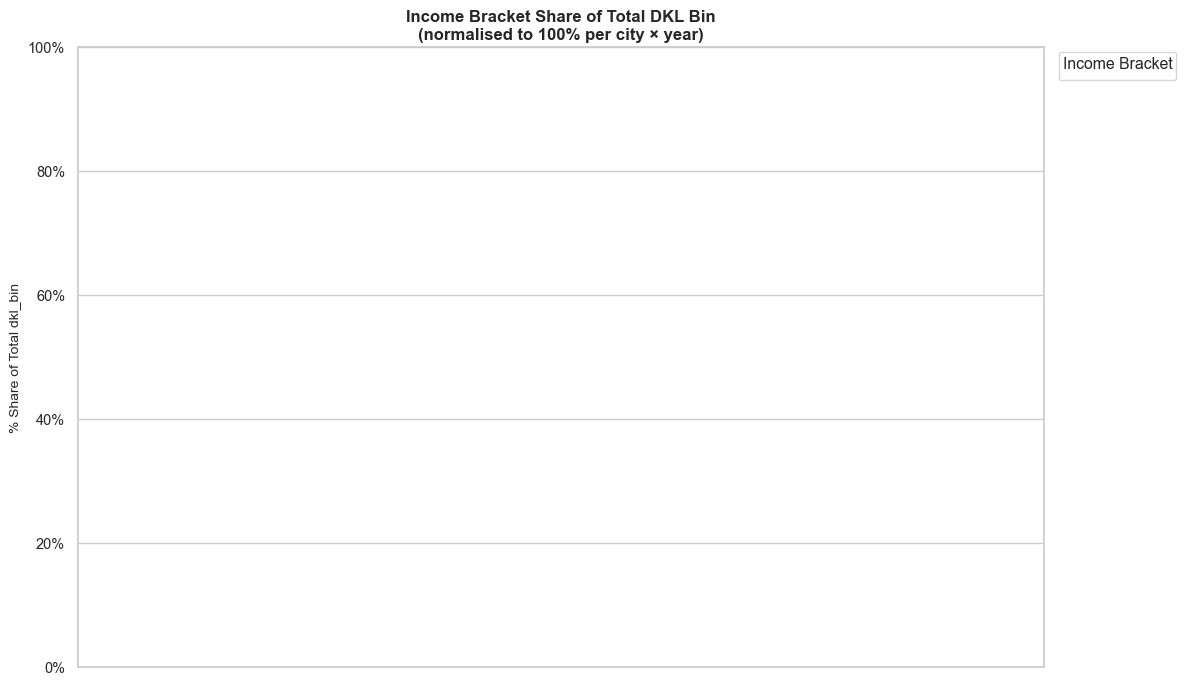

In [7]:
def plot_normalised_stacked(agg: pd.DataFrame, metric: str = 'median_dkl_bin') -> None:
    """Stacked 100% bar chart showing each bracket's share of total dkl_bin."""
    cities = sorted(agg['city_label'].unique())
    years  = sorted(agg['year'].unique())

    if hasattr(agg['bracket'], 'cat'):
        brackets = agg['bracket'].cat.categories.tolist()
    else:
        brackets = agg['bracket'].unique().tolist()

    # Pivot: rows = (city, year), cols = bracket
    pivot = agg.pivot_table(
        index=['city_label', 'year'],
        columns='bracket',
        values=metric,
        aggfunc='mean'
    ).reindex(columns=brackets)

    pivot_norm = pivot.div(pivot.sum(axis=1), axis=0) * 100
    pivot_norm.index = [
        f'{city}\n{yr}' for city, yr in pivot_norm.index
    ]

    cmap = plt.get_cmap('tab20', len(brackets))
    colors = [cmap(i) for i in range(len(brackets))]

    fig, ax = plt.subplots(figsize=(max(12, len(pivot_norm) * 1.0), 7))
    bottom = np.zeros(len(pivot_norm))

    for j, bracket in enumerate(brackets):
        if bracket not in pivot_norm.columns:
            continue
        vals = pivot_norm[bracket].fillna(0).values
        ax.bar(range(len(pivot_norm)), vals, bottom=bottom,
               color=colors[j], label=str(bracket),
               edgecolor='white', linewidth=0.2)
        bottom += vals

    ax.set_xticks(range(len(pivot_norm)))
    ax.set_xticklabels(pivot_norm.index, fontsize=8, rotation=30, ha='right')
    ax.set_ylabel('% Share of Total dkl_bin', fontsize=10)
    ax.set_title(
        'Income Bracket Share of Total DKL Bin\n(normalised to 100% per city × year)',
        fontsize=12, fontweight='bold'
    )
    ax.legend(
        bbox_to_anchor=(1.01, 1), loc='upper left',
        fontsize=7, title='Income Bracket'
    )
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    plt.tight_layout()
    plt.show()


plot_normalised_stacked(agg_income)


In [8]:
# Summary table
summary = (
    agg_income
    .groupby(['city_label', 'year'])['median_dkl_bin']
    .agg(total_dkl=('sum'), max_bracket=('max'), min_bracket=('min'))
    .round(6)
)
summary


,,total_dkl,max_bracket,min_bracket
city_label,year,,,
